# Using GATs and Edge Features to predict GDP
## Rahul Shiv, Andre Turati, and Peter Boennighausen

This is the companion Colab to our CS224W project on using graph attention networks to do node-level regression on GDP from the World Bank, with node-level features also from the World Bank and edge-level features from BACI. See the Medium post ___HERE___ for me details.

The following cells train the model and generate the plots shown in the article.

For the full code used in our project, split over multiple files and including checkpoint saving, see the Github at https://github.com/pboennig/gnns_for_gdp.

First, we install the packages that aren't already on Colab.

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.4 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 407 kB 38.7 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=6375b240834540d09f6a62dfc2e9ff6fecbbcf256b4b8e0fc26e0d9c68c50efa
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric


Next, we write some util functions for creating the PyG Data object, evaluating the model, and splitting between train, validation, and test.

Note that in this Colab, we operate on the CSVs we generated from the raw data. For the full pipeline from raw data onwards, see the Github.

In [ ]:
import torch
import pandas as pd
import random
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data

FIRST_YEAR = 1995
LAST_YEAR = 2019
FEATURES = ['pop', 'cpi', 'emp']
NUM_TRAIN = 15
NUM_VAL = 3
NUM_TEST = 6
NUM_EDGE_FEATURES = 10
EDGE_FEATURES = ['f'+str(i) for i in range(NUM_EDGE_FEATURES)]

# The data is found in the project's Github.
DOWNLOAD_PREFIX = 'https://raw.githubusercontent.com/pboennig/gnns_for_gdp/master/'

def create_data(year):
    '''
    For given year, pull in node features, edge features, and edge index and
    save in a PyG Data object.
    '''

    assert(year in range(FIRST_YEAR, LAST_YEAR + 1))
    edges = pd.read_csv(f'{DOWNLOAD_PREFIX}/output/X_EDGE_{year}.csv')

    # generate map from iso_code to ids of form [0, ..., num_unique_iso_codes - 1]
    iso_codes = set(edges['i'])
    iso_codes = iso_codes.union(set(edges['j']))
    iso_code_to_id = {code : i for (i, code) in enumerate(iso_codes)}

    # load in edge index
    edges['i_id'] = edges['i'].map(iso_code_to_id)
    edges['j_id'] = edges['j'].map(iso_code_to_id)
    edge_index = torch.from_numpy(edges[['i_id', 'j_id']].to_numpy(np.long)).t()
    edge_attr = torch.from_numpy(edges[EDGE_FEATURES].to_numpy(np.float32)) #extract the features from the dataset.
    edge_attr = (edge_attr - edge_attr.mean(axis=0)) / (edge_attr.std(axis=0))

    # load in target values
    y_df = pd.read_csv(f'{DOWNLOAD_PREFIX}/output/Y_{year}.csv')
    y_df['id'] = y_df['iso_code'].map(iso_code_to_id)
    y = torch.from_numpy(y_df.sort_values('id')[f'{year+1}'].to_numpy(np.float32)).unsqueeze(1)# get labels as tensor
    y = y.log() # log scale since spread of GDP is large

    # load in input features
    x_df = pd.read_csv(f'{DOWNLOAD_PREFIX}/output/X_NODE_{year}.csv')
    x_df['id'] = x_df['iso_code'].map(iso_code_to_id)
    features = ['pop', 'cpi', 'emp']
    x = torch.from_numpy(x_df.sort_values('id').loc[:,features].to_numpy(np.float32))
    x = (x - x.mean(axis=0)) / (x.std(axis=0))  # scale and center data
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def evaluate_model(model, data_iter):
    '''
    Accumulate MSE over a data list or loader.
    '''
    return sum([F.mse_loss(model(data), data.y).item() for data in data_iter])

def get_data():
    '''
    Generate data_lists for train, val, and test. These lists can be either loaded into data_loaders
    or indexed directly.
    '''

    data_list = [create_data(year) for year in range(FIRST_YEAR, LAST_YEAR)]
    random.shuffle(data_list)
    data_train = data_list[:NUM_TRAIN]
    data_val = data_list[NUM_TRAIN:NUM_TRAIN+NUM_VAL+1]
    data_test = data_list[NUM_TRAIN+NUM_VAL:]
    return (data_train, data_val, data_test)

We define a 2-layer GAT with no edge features.

In [ ]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
import random

class BaselineGDPModel(torch.nn.Module):
    def __init__(self, num_features=3, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size),
                      GATConv(self.hidden_size, self.hidden_size)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = self.linear(x)
        return F.relu(x) # since we know Y = log_gdp > 0, enforce via relu


We then define a 2-layer GAT _with_ edge features.

In [ ]:
# Basically the same as the baseline except we pass edge features
class GDPModel(torch.nn.Module):
    def __init__(self, num_features=3, hidden_size=32, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.target_size = target_size
        self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = NUM_EDGE_FEATURES),
                      GATConv(self.hidden_size, self.hidden_size, edge_dim = NUM_EDGE_FEATURES)]
        self.linear = nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        x = self.linear(x)

        return F.relu(x)

We define hyperparameters for training. These were used in our experiments after some searching, but feel free to play around.

In [ ]:
hyperparams = {
    'batch_size' : 3,
    'save_loss_interval' : 10,
    'print_interval' : 50,
    'save_model_interval' : 250,
    'n_epochs' : 1500,
    'learning_rate' : 0.01
}

In [ ]:
data_train, data_val, data_test = get_data() # the function described above, these data are what we'll work with

Our main training function.

In [ ]:
def train(model, name_prefix, hyperparams):
    '''
    Train model with given hyperparams dict.

    Saves the following CSVs over the course of training:
    1. the loss trajectory: the val and train loss every save_loss_interval epochs at
       filename 'results/{name_prefix}_{learning_rate}_train.csv' e.g. 'results/baseline_0.05_train.csv'
    2. every save_model_interval save both the model at e.g. 'models/baseline_0.05_0_out_of_1000.pt`
       and the predicted values vs actual values in `results/baseline_0.05_0_out_of_1000_prediction.csv' on the test data.
    '''
    learning_rate = hyperparams['learning_rate']
    batch_size = hyperparams['batch_size']
    n_epochs = hyperparams['n_epochs']
    save_loss_interval = hyperparams['save_loss_interval']
    print_interval = hyperparams['print_interval']
    save_model_interval = hyperparams['save_model_interval']

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    losses = []
    test_data = data_test[0]
    for epoch in range(n_epochs):
        epoch_loss = 0
        model.train()
        for data in loader:
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        if epoch % save_loss_interval == 0:
            val_loss = evaluate_model(model, data_val) / NUM_VAL
            train_loss = epoch_loss / NUM_TRAIN * batch_size
            if epoch % print_interval == 0:
                print("Epoch: {} Train loss: {:.2e} Validation loss: {:.2e}".format(epoch, train_loss, val_loss))
            losses.append((epoch, train_loss, val_loss))
        if epoch % save_model_interval == 0:
            # save predictions for plotting
            model.eval()

    return losses

The following cells may take a while, feel free to change the n_epochs in ``hyperparams`` above if you're in a rush!

In [ ]:
print("Training baseline...")
baseline = BaselineGDPModel()
baseline_loss_traj = train(baseline, "baseline", hyperparams)


Training baseline...
Epoch: 0 Train loss: 5.59e+02 Validation loss: 7.46e+02
Epoch: 50 Train loss: 2.34e+02 Validation loss: 3.04e+02
Epoch: 100 Train loss: 1.47e+02 Validation loss: 1.77e+02
Epoch: 150 Train loss: 1.13e+02 Validation loss: 1.40e+02
Epoch: 200 Train loss: 1.00e+02 Validation loss: 1.01e+02
Epoch: 250 Train loss: 8.89e+01 Validation loss: 8.75e+01
Epoch: 300 Train loss: 6.39e+01 Validation loss: 8.42e+01
Epoch: 350 Train loss: 5.60e+01 Validation loss: 6.77e+01
Epoch: 400 Train loss: 4.32e+01 Validation loss: 5.29e+01
Epoch: 450 Train loss: 3.73e+01 Validation loss: 5.05e+01
Epoch: 500 Train loss: 3.43e+01 Validation loss: 3.96e+01
Epoch: 550 Train loss: 2.76e+01 Validation loss: 3.22e+01
Epoch: 600 Train loss: 2.53e+01 Validation loss: 2.83e+01
Epoch: 650 Train loss: 2.21e+01 Validation loss: 2.35e+01
Epoch: 700 Train loss: 1.78e+01 Validation loss: 2.05e+01
Epoch: 750 Train loss: 1.42e+01 Validation loss: 1.69e+01
Epoch: 800 Train loss: 1.26e+01 Validation loss: 1.71e

In [ ]:
print("Training model...")
model = GDPModel() # needs to be double precision
model_loss_traj = train(model, "model", hyperparams)

Training model...
Epoch: 0 Train loss: 5.58e+02 Validation loss: 7.44e+02
Epoch: 50 Train loss: 2.97e+02 Validation loss: 3.69e+02
Epoch: 100 Train loss: 2.00e+02 Validation loss: 2.30e+02
Epoch: 150 Train loss: 1.45e+02 Validation loss: 1.72e+02
Epoch: 200 Train loss: 1.23e+02 Validation loss: 1.45e+02
Epoch: 250 Train loss: 1.07e+02 Validation loss: 1.27e+02
Epoch: 300 Train loss: 1.00e+02 Validation loss: 1.11e+02
Epoch: 350 Train loss: 6.79e+01 Validation loss: 9.03e+01
Epoch: 400 Train loss: 6.27e+01 Validation loss: 7.07e+01
Epoch: 450 Train loss: 4.87e+01 Validation loss: 8.02e+01
Epoch: 500 Train loss: 4.16e+01 Validation loss: 5.42e+01
Epoch: 550 Train loss: 3.54e+01 Validation loss: 4.94e+01
Epoch: 600 Train loss: 3.03e+01 Validation loss: 3.63e+01
Epoch: 650 Train loss: 2.44e+01 Validation loss: 2.88e+01
Epoch: 700 Train loss: 1.98e+01 Validation loss: 2.33e+01
Epoch: 750 Train loss: 1.72e+01 Validation loss: 2.14e+01
Epoch: 800 Train loss: 1.46e+01 Validation loss: 1.86e+01

Generate a plot comparing the loss trajectories of the baseline and edge features models.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

def comparison_plot(baseline_loss_traj, model_loss_traj):
    '''
    Plot the trajectory of a model's training from a dataframe that has train/val loss at each epoch.
    '''
    plt.yscale('log')
    # list(zip(*l)) unzips a list of tuples l into a list of lists
    # in our case, the first elem is epoch, second is train loss, third is val loss
    epoch, _, baseline_val = tuple(zip(*baseline_loss_traj))
    _, _, model_val = tuple(zip(*model_loss_traj))
    plt.plot(epoch, baseline_val, '-r', label='baseline')
    plt.plot(epoch, model_val, '-b', label='model')
    plt.legend(loc='upper right', title='model type')
    plt.yscale('log')
    plt.ylabel('log val MSE')
    plt.xlabel('epoch')
    plt.title(f'Comparing baseline and model with edge features')
    plt.show()
    plt.clf()

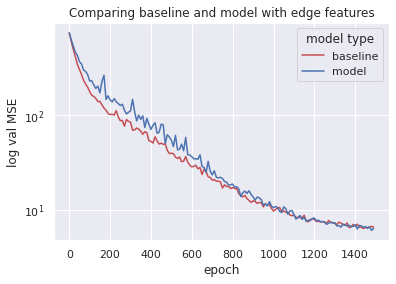

<Figure size 432x288 with 0 Axes>

In [ ]:
comparison_plot(baseline_loss_traj, model_loss_traj)

We then make a plot comparing our predictions to the ground truth.

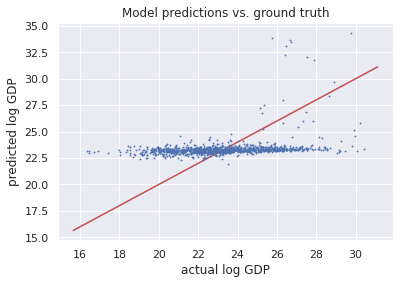

In [ ]:
ground_truth =[]
preds = []
for data in data_test:
  ground_truth += list(data.y.detach().numpy().squeeze())
  preds += list(model(data).detach().numpy().squeeze())
max_x = max(ground_truth)
max_x *= 1.15
plt.scatter(ground_truth, preds, s=.7, zorder=2)
l, r = plt.xlim()
plt.plot([l, r], [l, r], c='r', zorder=1)
plt.xlabel("actual log GDP")
plt.ylabel("predicted log GDP")
plt.title("Model predictions vs. ground truth")
plt.show()